# Test FastAPI

## Start FASTAPI
```bash
uvicorn --app-dir=phasenet app:app --reload --port 8001
uvicorn --app-dir=deepdenoiser app:app --reload --port 8003
```

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import obspy
import requests
sys.path.insert(0, os.path.abspath("../"))
np.random.seed(1000)

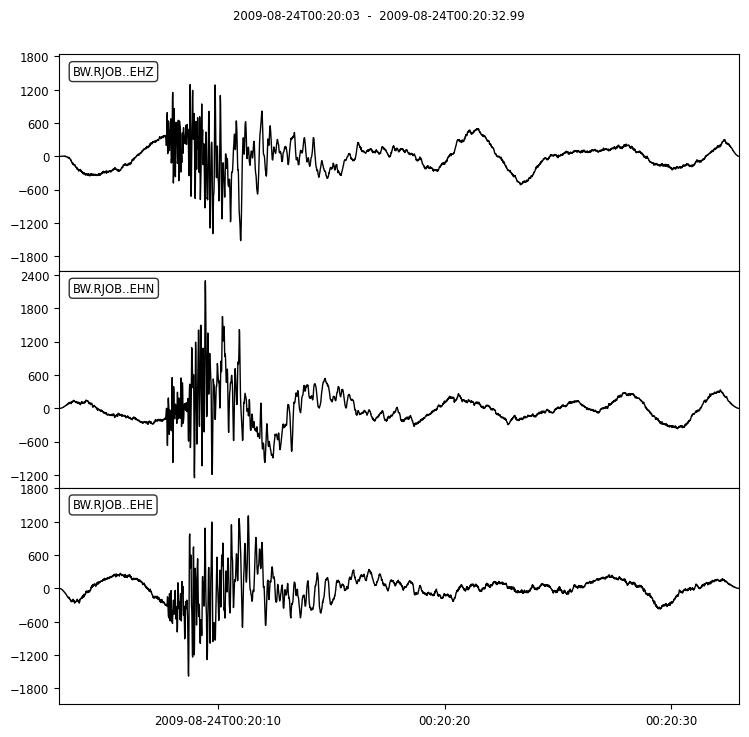

In [2]:
import obspy
stream = obspy.read()
stream.plot();

In [3]:
## Extract 3-component data
stream = stream.sort()
assert(len(stream) == 3)
data = []
for trace in stream:
    data.append(trace.data)
data = np.array(data).T
assert(data.shape[-1] == 3)
data_id = stream[0].get_id()[:-1]
timestamp = stream[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

## Add some noise
noisy_data = data + np.random.randn(*data.shape)*np.max(data)/5

## Test [DeepDenoiser](https://wayneweiqiang.github.io/DeepDenoiser)

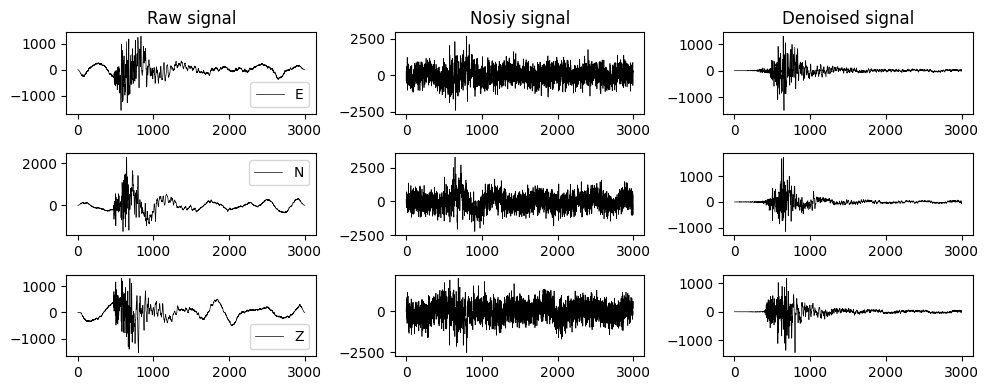

In [4]:
req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [noisy_data.tolist()]}

DEEPDENOISER_API_URL = "http://127.0.0.1:8003"
resp_deepdenoiser = requests.get(f'{DEEPDENOISER_API_URL}/predict', json=req)

denoised_data = np.array(resp_deepdenoiser.json()["vec"])

plt.figure(figsize=(10,4))
plt.subplot(331)
plt.plot(data[:,0], 'k', linewidth=0.5, label="E")
plt.legend()
plt.title("Raw signal")
plt.subplot(332)
plt.plot(noisy_data[:,0], 'k', linewidth=0.5, label="E")
plt.title("Nosiy signal")
plt.subplot(333)
plt.plot(denoised_data[0, :,0], 'k', linewidth=0.5, label="E")
plt.title("Denoised signal")
plt.subplot(334)
plt.plot(data[:,1], 'k', linewidth=0.5, label="N")
plt.legend()
plt.subplot(335)
plt.plot(noisy_data[:,1], 'k', linewidth=0.5, label="N")
plt.subplot(336)
plt.plot(denoised_data[0,:,1], 'k', linewidth=0.5, label="N")
plt.subplot(337)
plt.plot(data[:,2], 'k', linewidth=0.5, label="Z")
plt.legend()
plt.subplot(338)
plt.plot(noisy_data[:,2], 'k', linewidth=0.5, label="Z")
plt.subplot(339)
plt.plot(denoised_data[0,:,2], 'k', linewidth=0.5, label="Z")
plt.tight_layout()
plt.show();

## Test [PhaseNet](https://wayneweiqiang.github.io/PhaseNet)

In [5]:
PHASENET_API_URL = "http://127.0.0.1:8001"
resp = requests.get(f'{PHASENET_API_URL}/predict', json=req)
print('Picks', resp.json())

Picks [{'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:08.690', 'prob': 0.41293007135391235, 'amp': 3281.9875522716266, 'type': 's'}]


Picks [{'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:08.690', 'prob': 0.41293007135391235, 'amp': 3281.9875522716266, 'type': 's'}]


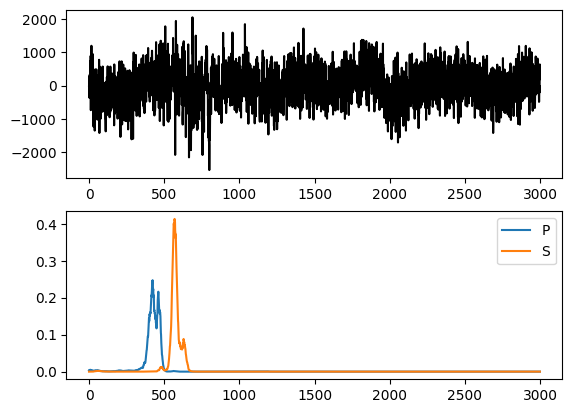

In [6]:
PHASENET_API_URL = "http://127.0.0.1:8001"
resp = requests.get(f'{PHASENET_API_URL}/predict_prob', json=req)
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

plt.figure()
plt.subplot(211)
plt.plot(noisy_data[:,-1], 'k', label="Z")
plt.subplot(212)
plt.plot(preds[0, :, 0, 1], label="P")
plt.plot(preds[0, :, 0, 2], label="S")
plt.legend()
plt.show();

## Test [DeepDenoiser](https://wayneweiqiang.github.io/DeepDenoiser) + [PhaseNet](https://wayneweiqiang.github.io/PhaseNet)

In [7]:
PHASENET_API_URL = "http://127.0.0.1:8001"
resp = requests.get(f'{PHASENET_API_URL}/predict', json=resp_deepdenoiser.json())
print('Picks', resp.json())

Picks [{'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:07.030', 'prob': 0.763781726360321, 'amp': 1741.8168170560068, 'type': 'p'}, {'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:08.610', 'prob': 0.5108724236488342, 'amp': 1741.8168170560068, 'type': 's'}]


Picks [{'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:07.030', 'prob': 0.763781726360321, 'amp': 1741.8168170560068, 'type': 'p'}, {'id': 'BW.RJOB..EH', 'timestamp': '2009-08-24T00:20:08.610', 'prob': 0.5108724236488342, 'amp': 1741.8168170560068, 'type': 's'}]


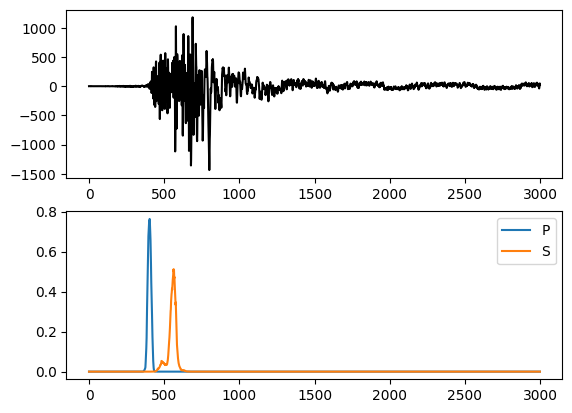

In [8]:
PHASENET_API_URL = "http://127.0.0.1:8001"
resp = requests.get(f'{PHASENET_API_URL}/predict_prob', json=resp_deepdenoiser.json())
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

plt.figure()
plt.subplot(211)
plt.plot(denoised_data[0,:,-1], 'k', label="Z")
plt.subplot(212)
plt.plot(preds[0, :, 0, 1], label="P")
plt.plot(preds[0, :, 0, 2], label="S")
plt.legend()
plt.show();